In [100]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [101]:
!nvidia-smi

Sat Feb 19 13:54:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    72W / 149W |    658MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [102]:
torch.manual_seed(2022)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
print(device)

cuda


In [105]:
# Preparing MNIST Dataset
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,),std=(0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data',download = True,transform=transform,train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data',download = True,transform=transform,train=False)

trainloader = torch.utils.data.DataLoader(dataset = trainset,shuffle=True,batch_size = batch_size)
testloader = torch.utils.data.DataLoader(dataset = testset,shuffle=False,batch_size = batch_size)

In [106]:
print(len(trainloader),len(testloader))

469 79


In [107]:
mnist_dim = trainset.data.size(1)*trainset.data.size(2)
print(mnist_dim)

784


torch.Size([1, 28, 28])


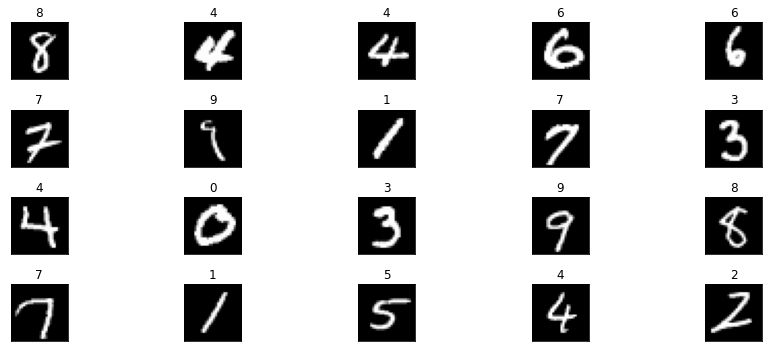

In [108]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images[0].shape)
fig = plt.figure(figsize = (15,5))
for idx in range(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [110]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc1 = nn.Linear(100,7*7*256)
    self.upsample1 = nn.ConvTranspose2d(256,128,kernel_size=(5,5),stride=(1,1),padding=(2,2))
    self.upsample2 = nn.ConvTranspose2d(128,64,kernel_size=(5,5),stride=(2,2),padding=(2,2))
    self.upsample3 = nn.ConvTranspose2d(64,1,kernel_size=(4,4),stride=(2,2))
    self.bn1 = torch.nn.BatchNorm1d(7*7*256)
    self.bn2 = torch.nn.BatchNorm2d(128)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(0.3)
  def forward(self,x):
    bs = x.shape[0]
    x  = self.fc1(x)
    x = self.bn1(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = torch.reshape(x,(bs,256,7,7))
    x = self.upsample1(x)
    x = self.bn2(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = self.upsample2(x)
    x = self.bn3(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = self.upsample3(x)
    return x
  
#Discrimator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1  = nn.Conv2d(1,64,kernel_size=(5,5),stride=(2,2),padding = (2,2))
    self.conv2 = nn.Conv2d(64,128,kernel_size=(5,5),stride=(2,2),padding=(2,2))
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(6272,1)
  def forward(self,x):
    x = self.conv1(x)
    x = F.leaky_relu(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = F.leaky_relu(x)
    x = self.dropout(x)
    x = torch.flatten(x,start_dim = 1 )
    x = self.fc1(x)
    return torch.sigmoid(x)

In [111]:
generator = Generator()
generator.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=12544, bias=True)
  (upsample1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upsample2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (upsample3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [112]:
z = torch.normal(mean = 0, std = 1,size=(1,100)).to(device)
generator.eval()
print(z.shape)
op = generator.forward(z).detach()
print(op.shape)

torch.Size([1, 100])
torch.Size([1, 1, 28, 28])


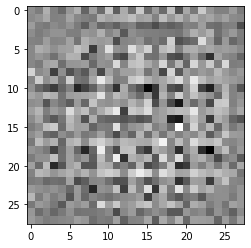

In [113]:
plt.imshow(op.to('cpu')[0, 0, :, :], cmap='gray')

In [114]:
discrim = Discriminator()
discrim.to(device)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=1, bias=True)
)

In [115]:
img = images[0]
print(img.shape)
discrim.eval()
op = discrim.forward(img.to(device).reshape(1,1,28,28))
print(op)

torch.Size([1, 28, 28])
tensor([[0.5073]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [116]:
criterion = nn.BCELoss().to(device)

In [117]:
g_optim = optim.Adam(generator.parameters(),lr = 0.0002)
d_optim = optim.Adam(discrim.parameters(),lr = 0.0002)

In [125]:
def generator_loss(fake_output):
  return criterion(fake_output,torch.ones_like(fake_output))


def discriminator_loss(real_output,fake_output):
  real_loss = criterion(real_output,torch.ones_like(real_output))
  fake_loss = criterion(fake_output,torch.zeros_like(fake_output))
  return (real_loss+fake_loss)

In [126]:
def D_train(x):
    d_optim.zero_grad()
    discrim.train()
    generator.eval()
    bs = x.shape[0]
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    D_output = discrim(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output
    z = Variable(torch.randn(bs, 100).to(device))
    x_fake, y_fake = generator(z), Variable(torch.zeros(bs, 1).to(device))
    D_output = discrim(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output
    D_loss = D_real_loss + D_fake_loss
    loss = D_loss
    D_loss.backward()
    d_optim.step()
    return  loss.item()

def G_train(x):
    g_optim.zero_grad()
    generator.train()
    discrim.eval()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, 100).to(device))
    y = Variable(torch.ones(bs, 1).to(device))
    G_output = generator(z)
    D_output = discrim(G_output)
    G_loss = criterion(D_output, y)
    loss = G_loss
    G_loss.backward()
    g_optim.step()
    return G_loss.item()

In [128]:
n_epoch = 75
d_loss = []
g_loss = []
k=1
for epoch in range(1, n_epoch+1):
    discrim.train()
    generator.train()         
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(trainloader):
      for rep in range(k):
        D_losses.append(D_train(x))
      G_losses.append(G_train(x))
    d_loss.append(torch.mean(torch.FloatTensor(D_losses)))
    g_loss.append(torch.mean(torch.FloatTensor(G_losses)))
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/75]: loss_d: 0.066, loss_g: 5.531
[2/75]: loss_d: 0.088, loss_g: 5.037
[3/75]: loss_d: 0.098, loss_g: 4.837
[4/75]: loss_d: 0.118, loss_g: 4.452
[5/75]: loss_d: 0.125, loss_g: 4.197
[6/75]: loss_d: 0.128, loss_g: 4.055
[7/75]: loss_d: 0.148, loss_g: 3.863
[8/75]: loss_d: 0.143, loss_g: 3.786
[9/75]: loss_d: 0.160, loss_g: 3.706
[10/75]: loss_d: 0.156, loss_g: 3.674
[11/75]: loss_d: 0.164, loss_g: 3.624
[12/75]: loss_d: 0.170, loss_g: 3.591
[13/75]: loss_d: 0.170, loss_g: 3.551
[14/75]: loss_d: 0.180, loss_g: 3.384
[15/75]: loss_d: 0.188, loss_g: 3.448
[16/75]: loss_d: 0.178, loss_g: 3.513
[17/75]: loss_d: 0.184, loss_g: 3.377
[18/75]: loss_d: 0.189, loss_g: 3.454
[19/75]: loss_d: 0.192, loss_g: 3.346
[20/75]: loss_d: 0.187, loss_g: 3.394
[21/75]: loss_d: 0.197, loss_g: 3.355
[22/75]: loss_d: 0.181, loss_g: 3.414
[23/75]: loss_d: 0.192, loss_g: 3.291
[24/75]: loss_d: 0.192, loss_g: 3.316
[25/75]: loss_d: 0.195, loss_g: 3.357
[26/75]: loss_d: 0.191, loss_g: 3.286
[27/75]: loss_d: 0.18

Some Images generated by the generator:


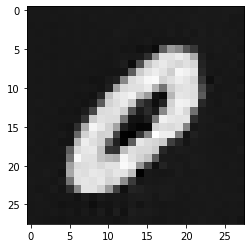

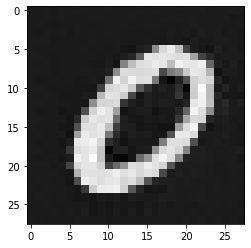

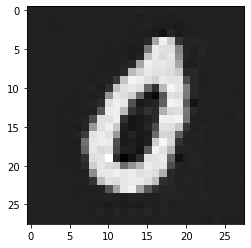

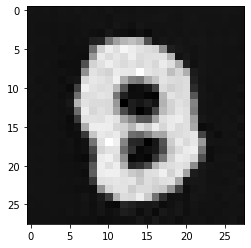

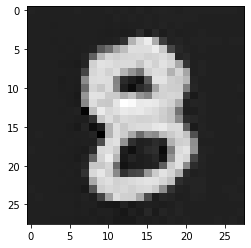

In [156]:
generator.eval()
with torch.no_grad():
  test_z = Variable(torch.randn(5, 100).to(device))
  gz = generator(test_z)
  print("Some Images generated by the generator:")
  for image in gz:
    plt.imshow(image.to('cpu')[0, :, :], cmap='gray')
    plt.show()